# Loading data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation 
from pyts.image import MarkovTransitionField
import dask.dataframe as dd  
import pandas as pd


from scipy import signal as sign
from PIL import Image
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import matthews_corrcoef

import warnings
warnings.filterwarnings('ignore')

In [2]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

root_dir = "/home/polivares/scratch/Datasets/PowerLineFaults/"

X_train = np.load(root_dir + "dataset_mfcc/train/images_train.npy")
y_train = np.load(root_dir + "dataset_mfcc/train/labels_train.npy")
X_test = np.load(root_dir + "dataset_mfcc/test/images_test.npy")
y_test = np.load(root_dir + "dataset_mfcc/test/labels_test.npy")
X_val = np.load(root_dir + "dataset_mfcc/val/images_val.npy")
y_val = np.load(root_dir + "dataset_mfcc/val/labels_val.npy")

2022-10-07 15:52:17.267075: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-07 15:52:17.454097: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-07 15:52:18.243176: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-10-07 15:52:18.243272: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

# CNN-model

In [3]:
# Creación de modelo
model = models.Sequential()
# Capas encargadas de obtener información de la imagen
model.add(layers.Conv2D(256, (3, 3), activation='relu', input_shape=(256,256,1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
# Capas para la clasificación en base a la información obtenida en 
# capas anteriores
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation = 'sigmoid'))
model.summary()

2022-10-07 15:52:19.946621: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-07 15:52:20.721340: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9638 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:02:00.0, compute capability: 7.5


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 256)     2560      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 256)    0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 128)     295040    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 64)        73792     
                                                                 
 flatten (Flatten)           (None, 230400)            0

In [4]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(patience = 7)

checkpoint_path='CNN-model_mfcc.ckpt'
# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

model.compile(loss = 'bce', optimizer = 'adam', metrics=['accuracy', tf.keras.metrics.Recall()])
history_cnn = model.fit(X_train, y_train, epochs=100, 
                        validation_data=(X_val, y_val),
                        batch_size=10,
                        callbacks=[early_stopping, cp_callback])

Epoch 1/100


2022-10-07 15:52:24.501436: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8204


488/488 [==============================] - ETA: 0s - loss: 13.2495 - accuracy: 0.9221 - recall: 0.0102
Epoch 1: saving model to CNN-model_mfcc.ckpt
488/488 [==============================] - 26s 45ms/step - loss: 13.2495 - accuracy: 0.9221 - recall: 0.0102 - val_loss: 0.2696 - val_accuracy: 0.9402 - val_recall: 0.0000e+00
Epoch 2/100
487/488 [============================>.] - ETA: 0s - loss: 0.4814 - accuracy: 0.9351 - recall: 0.0034
Epoch 2: saving model to CNN-model_mfcc.ckpt
488/488 [==============================] - 21s 44ms/step - loss: 0.4812 - accuracy: 0.9350 - recall: 0.0034 - val_loss: 0.2392 - val_accuracy: 0.9402 - val_recall: 0.0000e+00
Epoch 3/100
487/488 [============================>.] - ETA: 0s - loss: 0.2293 - accuracy: 0.9400 - recall: 0.0102
Epoch 3: saving model to CNN-model_mfcc.ckpt
488/488 [==============================] - 21s 44ms/step - loss: 0.2295 - accuracy: 0.9399 - recall: 0.0102 - val_loss: 0.2209 - val_accuracy: 0.9402 - val_recall: 0.0137
Epoch 4/100


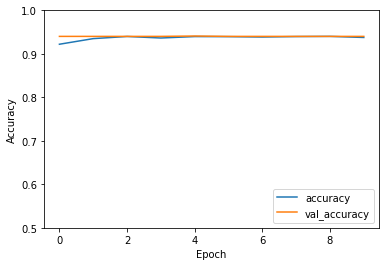

In [5]:
plt.plot(history_cnn.history['accuracy'], label='accuracy')
plt.plot(history_cnn.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.show()

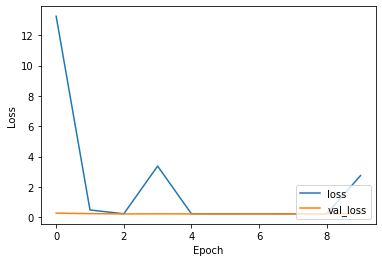

In [6]:
plt.plot(history_cnn.history['loss'], label='loss')
plt.plot(history_cnn.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')
plt.show()

In [7]:
val_loss, val_acc, val_recall = model.evaluate(X_val,  y_val, verbose=2, batch_size=4)

305/305 - 3s - loss: 0.2286 - accuracy: 0.9402 - recall: 0.0000e+00 - 3s/epoch - 9ms/step


In [8]:
val_predictions = (model.predict(X_val, batch_size=4)>0.5).reshape(1,-1)[0].astype(int)
val_real_values = y_val.T[0]

305/305 [==============================] - 2s 5ms/step


In [9]:
matthews_corrcoef(val_real_values, val_predictions)

0.0

In [10]:
test_loss, test_acc, test_recall = model.evaluate(X_test,  y_test, verbose=2, batch_size=4)

654/654 - 5s - loss: 0.2298 - accuracy: 0.9396 - recall: 0.0000e+00 - 5s/epoch - 7ms/step


In [11]:
test_predictions = (model.predict(X_test, batch_size=4)>0.5).reshape(1,-1)[0].astype(int)
test_real_values = y_test.T[0]

654/654 [==============================] - 3s 5ms/step


In [12]:
matthews_corrcoef(test_real_values, test_predictions)

0.0

# Resnet-model

In [13]:
# Transfer Learning
base_model = tf.keras.applications.ResNet50(include_top=False, weights='imagenet', input_shape=(256, 256, 3))
avg = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
output = tf.keras.layers.Dense(1, activation="sigmoid")(avg)

model = tf.keras.Model(inputs=base_model.input, outputs=output)

for layer in base_model.layers:
    layer.trainable = False # Esto impide que las capas se re entrenen

In [14]:
X_train_rgb = np.repeat(X_train, 3, -1)
X_val_rgb = np.repeat(X_val, 3, -1)

In [15]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(patience = 7)

checkpoint_path='Resnet50-model_mfcc.ckpt'
# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

model.compile(loss = 'bce', optimizer = 'adam', metrics=['accuracy', tf.keras.metrics.Recall()])
history_resnet = model.fit(X_train_rgb, y_train, epochs=100, 
                        validation_data=(X_val_rgb, y_val),
                        batch_size=10,
                        callbacks=[early_stopping, cp_callback])

Epoch 1/100
488/488 [==============================] - ETA: 0s - loss: 0.1925 - accuracy: 0.9399 - recall_1: 0.0374
Epoch 1: saving model to Resnet50-model_mfcc.ckpt
488/488 [==============================] - 24s 42ms/step - loss: 0.1925 - accuracy: 0.9399 - recall_1: 0.0374 - val_loss: 0.1637 - val_accuracy: 0.9426 - val_recall_1: 0.0411
Epoch 2/100
488/488 [==============================] - ETA: 0s - loss: 0.1678 - accuracy: 0.9412 - recall_1: 0.0816
Epoch 2: saving model to Resnet50-model_mfcc.ckpt
488/488 [==============================] - 18s 36ms/step - loss: 0.1678 - accuracy: 0.9412 - recall_1: 0.0816 - val_loss: 0.1498 - val_accuracy: 0.9484 - val_recall_1: 0.1918
Epoch 3/100
488/488 [==============================] - ETA: 0s - loss: 0.1622 - accuracy: 0.9414 - recall_1: 0.1259
Epoch 3: saving model to Resnet50-model_mfcc.ckpt
488/488 [==============================] - 18s 36ms/step - loss: 0.1622 - accuracy: 0.9414 - recall_1: 0.1259 - val_loss: 0.1504 - val_accuracy: 0.9434 

Epoch 25/100
488/488 [==============================] - ETA: 0s - loss: 0.1134 - accuracy: 0.9606 - recall_1: 0.4320
Epoch 25: saving model to Resnet50-model_mfcc.ckpt
488/488 [==============================] - 18s 36ms/step - loss: 0.1134 - accuracy: 0.9606 - recall_1: 0.4320 - val_loss: 0.1277 - val_accuracy: 0.9508 - val_recall_1: 0.2055
Epoch 26/100
488/488 [==============================] - ETA: 0s - loss: 0.1126 - accuracy: 0.9617 - recall_1: 0.4354
Epoch 26: saving model to Resnet50-model_mfcc.ckpt
488/488 [==============================] - 18s 37ms/step - loss: 0.1126 - accuracy: 0.9617 - recall_1: 0.4354 - val_loss: 0.1207 - val_accuracy: 0.9566 - val_recall_1: 0.3836
Epoch 27/100
487/488 [============================>.] - ETA: 0s - loss: 0.1123 - accuracy: 0.9593 - recall_1: 0.4218
Epoch 27: saving model to Resnet50-model_mfcc.ckpt
488/488 [==============================] - 18s 36ms/step - loss: 0.1121 - accuracy: 0.9594 - recall_1: 0.4218 - val_loss: 0.1373 - val_accuracy: 0

Epoch 49/100
487/488 [============================>.] - ETA: 0s - loss: 0.0987 - accuracy: 0.9678 - recall_1: 0.5188
Epoch 49: saving model to Resnet50-model_mfcc.ckpt
488/488 [==============================] - 18s 36ms/step - loss: 0.0988 - accuracy: 0.9676 - recall_1: 0.5170 - val_loss: 0.1135 - val_accuracy: 0.9574 - val_recall_1: 0.4247
Epoch 50/100
488/488 [==============================] - ETA: 0s - loss: 0.0967 - accuracy: 0.9658 - recall_1: 0.5102
Epoch 50: saving model to Resnet50-model_mfcc.ckpt
488/488 [==============================] - 18s 37ms/step - loss: 0.0967 - accuracy: 0.9658 - recall_1: 0.5102 - val_loss: 0.1228 - val_accuracy: 0.9574 - val_recall_1: 0.3425
Epoch 51/100
488/488 [==============================] - ETA: 0s - loss: 0.0961 - accuracy: 0.9668 - recall_1: 0.5170
Epoch 51: saving model to Resnet50-model_mfcc.ckpt
488/488 [==============================] - 18s 37ms/step - loss: 0.0961 - accuracy: 0.9668 - recall_1: 0.5170 - val_loss: 0.1208 - val_accuracy: 0

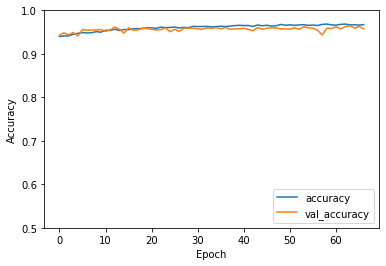

In [16]:
plt.plot(history_resnet.history['accuracy'], label='accuracy')
plt.plot(history_resnet.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.show()

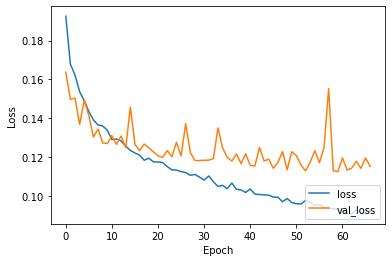

In [17]:
plt.plot(history_resnet.history['loss'], label='loss')
plt.plot(history_resnet.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')
plt.show()

In [18]:
val_loss, val_acc, val_recall = model.evaluate(X_val_rgb,  y_val, verbose=2, batch_size=4)

2022-10-07 16:16:41.400998: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.27GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2022-10-07 16:16:41.401083: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.27GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2022-10-07 16:16:41.408071: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.29GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2022-10-07 16:16:41.408110: W tensorflow/core/common_runtime/bfc_allocato

305/305 - 8s - loss: 0.1153 - accuracy: 0.9574 - recall_1: 0.4658 - 8s/epoch - 27ms/step


In [19]:
val_predictions = (model.predict(X_val_rgb, batch_size=4)>0.5).reshape(1,-1)[0].astype(int)
val_real_values = y_val.T[0]

305/305 [==============================] - 8s 25ms/step


In [20]:
matthews_corrcoef(val_real_values, val_predictions)

0.560018240991064

In [ ]:
X_test_rgb = np.repeat(X_test, 3, -1)
test_loss, test_acc, test_recall = model.evaluate(X_test_rgb,  y_test, verbose=2, batch_size=4)

In [ ]:
test_predictions = (model.predict(X_test_rgb, batch_size=4)>0.5).reshape(1,-1)[0].astype(int)
test_real_values = y_test.T[0]

In [ ]:
matthews_corrcoef(test_real_values, test_predictions)